# Import packages

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import inspect
from collections import namedtuple
import sys
from pyprojroot import here
import feather
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim" / "tides"
from tidal_flat_0d import models, features, visualization
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

# Import data

In [161]:
tide_name = "tides-debug.feather"
tide_name = "1yr_30s.feather"
tide_series = features.load_tide(wdir, tide_name)

index = tide_series.pressure.index
water_height = tide_series.pressure.values

# Make functions

## Turn tide data into functions for height and gradient

In [162]:
tide_func = interp1d(np.arange(1,len(index)+1,1), water_height, bounds_error=False, fill_value="extrapolate")
dhdt = np.gradient(water_height)
dhdt_func = interp1d(np.arange(0,len(index),1), dhdt, bounds_error=False, fill_value="extrapolate")

## Concentration function using Runge-Kutta Method

In [163]:
def solve_conc(t, y, init_elev, bound_conc, settle_rate, bulk_dens):

    init_conc = y[0]
    water_height = tide_func(t)
    dhdt = dhdt_func(t)
    depth = water_height - init_elev

    # Checks
    tide_increasing = dhdt > 0

    if tide_increasing:
        delta_conc = - (settle_rate * init_conc) / depth - 1 / depth * (init_conc - bound_conc) * dhdt
        if init_conc + delta_conc < 0:
            delta_conc = - init_conc
        print(init_conc, delta_conc, init_conc + delta_conc)
        return delta_conc
    if not tide_increasing:
        delta_conc = - (settle_rate * init_conc) / depth
        if init_conc + delta_conc < 0:
            delta_conc = - init_conc
        print(init_conc, delta_conc, init_conc + delta_conc)
        return delta_conc

In [164]:
def solve_conc(t, y, bound_conc, settle_rate, bulk_dens):

    init_conc = y[0]
    init_elev = y[1]
    water_height = tide_func(t)
    depth = water_height - init_elev
    
    if depth <= 0 and init_conc > 0:
        delta_conc = - init_conc
        delta_elev = 0
        y = [delta_conc, delta_elev]
        print('UP (t={}):: init_conc {:.2f}, delta_conc {:.2f}, new_conc {:.2f}, init_elev {:.8f}, delta_elev {:.8f}, new_elev {:.8f}'.format(init_conc, delta_conc, init_conc + delta_conc, init_elev, delta_elev, init_elev + delta_elev))
        return y
    elif depth <= 0 and init_conc <= 0:
        delta_conc = 0
        delta_elev = 0
        y = [delta_conc, delta_elev]
        print('UP (t={}):: init_conc {:.2f}, delta_conc {:.2f}, new_conc {:.2f}, init_elev {:.8f}, delta_elev {:.8f}, new_elev {:.8f}'.format(t, init_conc, delta_conc, init_conc + delta_conc, init_elev, delta_elev, init_elev + delta_elev))
        return y

    dhdt = dhdt_func(t)
    tide_increasing = dhdt > 0

    if tide_increasing:
        delta_conc = - (settle_rate * init_conc) / depth - 1 / depth * (init_conc - bound_conc) * dhdt
        if init_conc + delta_conc < 0:
            print(depth, dhdt)
            delta_conc = - init_conc
        delta_elev = settle_rate * (init_conc + delta_conc) / bulk_dens
        y = [delta_conc, delta_elev]
        print('OP-I (t={}):: init_conc {:.2f}, delta_conc {:.2f}, new_conc {:.2f}, init_elev {:.8f}, delta_elev {:.8f}, new_elev {:.8f}'.format(t, init_conc, delta_conc, init_conc + delta_conc, init_elev, delta_elev, init_elev + delta_elev))
        return y
    if not tide_increasing:
        delta_conc = - (settle_rate * init_conc) / depth
        if init_conc + delta_conc < 0:
            delta_conc = - init_conc
            print(depth, dhdt)
        delta_elev = settle_rate * (init_conc + delta_conc) / bulk_dens
        y = [delta_conc, delta_elev]
        print('OP-D (t={}):: init_conc {:.2f}, delta_conc {:.2f}, new_conc {:.2f}, init_elev {:.8f}, delta_elev {:.8f}, new_elev {:.8f}'.format(t, init_conc, delta_conc, init_conc + delta_conc, init_elev, delta_elev, init_elev + delta_elev))
        return y

In [165]:
def solve_conc(t, y, bound_conc, settle_rate, bulk_dens):
    
    init_conc = y[0]
    init_elev = y[1]
    water_height = tide_func(t)
    dhdt = dhdt_func(t)
    depth = water_height - init_elev
    
    if depth < 0:
        delta_conc = 0
        delta_elev = 0
        return [delta_conc, delta_elev]

    # Checks
    tide_increasing = dhdt > 0
    
    H = 1
    if not tide_increasing:
        H = 0
        
    delta_elev = settle_rate * init_conc / bulk_dens
    delta_conc = - (settle_rate * init_conc) / depth - H / depth * (init_conc - bound_conc) * dhdt
    
    
    return [delta_conc, delta_elev]

def flood_event(t, y, *args):
    elev = y[1]
    water_height = tide_func(t)
    depth = water_height - elev
    return depth
flood_event.terminal = False
flood_event.direction = 0

# Set parameters and run model for one cycle

In [166]:
grain_dia = 0.000035  # grain diameter (m)
grain_den = 2650
settle_rate = models.stokes_settling(grain_dia=grain_dia, grain_den=grain_den)
init_conc = 0
bound_conc = 0.8
init_elev = 0
bulk_dens = 1100

last_t = 1.000000000
prev_delta = 0.0
prev_conc = 0.0

t_span = np.arange(1,len(index), 1)

sol = solve_ivp(fun=solve_conc, t_span=[t_span[0], t_span[-1]], y0=[init_conc, init_elev], args=(bound_conc, settle_rate, bulk_dens), dense_output=True, events=flood_event)
print(sol.message)

Required step size is less than spacing between numbers.


In [170]:
sol.y

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

# Plot results

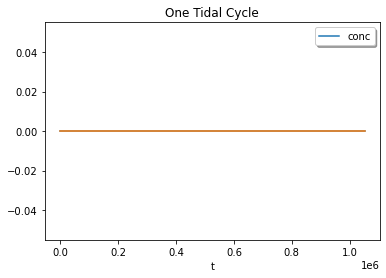

In [167]:
t = np.linspace(1, len(index), 1000)
z = sol.sol(t)
plt.plot(t, z.T)
plt.xlabel('t')
plt.legend(['conc'], shadow=True)
plt.title('One Tidal Cycle')
plt.show()